# Phonon calculations for ZIF-8 (CP2K + Phonopy) 
Goal: finite-displacement phonons using CP2K forces and Phonopy.

**Outline**:
1) Environment & inputs
2) Symmetrization with phonopy
3) Generate displacements with phonopy
4) Run CP2K single-point forces for each displacement 
5) Build force constants
6) Plot Phonon Bands/DOS 
7) Checks for imaginary modes

Notes:
- Use your relaxed ZIF-8 structure as `R2SCAN.inp`.


## 1) Environment & inputs
- CP2K and Phonopy are available (via module or conda).
- Base CP2K input: after relaxing the cell with CP2K, use the restart file as the starting point for the phonon calculation.  
  In this example, `R2SCAN-1.restart`. Copy it into your phonon directory as `R2SCAN.inp`.

## 2) Symmetrization
This command symmetrizes the structure according to the specified tolerance. Achieving higher symmetry reduces the number of supercells required for the phonon calculation.

For ZIF-8, a tolerance of **0.0005** is sufficient to detect the **I23** space group.

In [1]:
%%bash
phonopy --cp2k -c R2SCAN.inp --symmetry --tolerance 0.0005 


phonopy_version: '2.29.1'
space_group_type: 'I23'
space_group_number: 197
point_group_type: '23'
space_group_operations:
- rotation: # 1
  - [ 1,  0 , 0]
  - [ 0,  1 , 0]
  - [ 0,  0 , 1]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 2
  - [-1,  0 , 0]
  - [ 0, -1 , 0]
  - [ 0,  0 , 1]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 3
  - [ 1,  0 , 0]
  - [ 0, -1 , 0]
  - [ 0,  0 ,-1]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 4
  - [-1,  0 , 0]
  - [ 0,  1 , 0]
  - [ 0,  0 ,-1]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 5
  - [ 0,  0 , 1]
  - [ 1,  0 , 0]
  - [ 0,  1 , 0]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 6
  - [ 0,  0 , 1]
  - [-1,  0 , 0]
  - [ 0, -1 , 0]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 7
  - [ 0,  0 ,-1]
  - [ 1,  0 , 0]
  - [ 0, -1 , 0]
  translation: [ 0.00000,  0.00000,  0.00000 ]
- rotation: # 8
  - [ 0,  0 ,-1]
  - [-1,  0 , 0]
  - [ 0,  1 , 0]
  translation:

This command generates two input files:

- Punitcell.inp: Primitive unit cell.
- Bunitcell.inp: Conventional unit cell.

In this example, we use the conventional unit cell, which is generally preferable for accurate phonon calculations.

In both cases, the script automatically adds:
  - `RUN_TYPE ENERGY_FORCE`
  - `&PRINT/&FORCES FILENAME forces`

These are required because we run a single-point calculation to obtain the forces for each supercell. Make sure the other settings (basis sets, pseudopotentials, and cutoffs) are maintained.


## 3) Generate displacements
Replace `1 1 1` and amplitude as needed. The command writes supercells.
In this case the space group is **I23** and the number of inequivalent atoms is 69. Therefore, 69 supercells are generated.

Phonopy saves the summary of the calculation to `phonopy_disp.yaml`


In [2]:
%%bash
phonopy --cp2k -c Bunitcell.inp -d --dim "1 1 1" --amplitude 0.01


        _
  _ __ | |__   ___  _ __   ___   _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ | '_ \| | | |
 | |_) | | | | (_) | | | | (_) || |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___(_) .__/ \__, |
 |_|                            |_|    |___/
                                      2.29.1

Python version 3.11.10
Spglib version 2.6.0

Calculator interface: cp2k
Crystal structure was read from "Bunitcell.inp".
Unit of length: angstrom
Displacements creation mode
Displacement distance: 0.01
Settings:
  Supercell: [1 1 1]
Spacegroup: I23 (197)
Number of symmetry operations in supercell: 24
Use -v option to watch primitive cell, unit cell, and supercell structures.

"phonopy_disp.yaml" and supercells have been created.

Summary of calculation was written in "phonopy_disp.yaml".
                 _
   ___ _ __   __| |
  / _ \ '_ \ / _` |
 |  __/ | | | (_| |
  \___|_| |_|\__,_|



To keep it tidy, I use this function to create a directory for each supercell:

In [ ]:
from pathlib import Path
import re

def tidy_supercells(pattern="*supercell*.inp"):
    p = Path(".")
    for f in sorted(p.glob(pattern)):
        m = re.search(r"supercell-(\d+)\.inp$", f.name)
        d = p / (f"{int(m.group(1)):02d}" if m else "00")
        d.mkdir(exist_ok=True)
        f.rename(d / f.name)

In [7]:
cp2k_dir = "/user/j.santanaandreo/u12658/files_CP2K/MOF-5"
tidy_supercells()


## 4) Run CP2K force calculations for each displaced structure

This function writes a **SLURM array job** script (`cp2k_array.job`) to run one CP2K force calculation per displaced supercell folder.  
Pass:
- `total` — total number of supercells (folders named `01`, `02`, …).
- `parallel` — maximum number of array tasks to run **concurrently**.

Each array task `cd`s into its folder, picks the first `*.inp`, and runs `cp2k.psmp` with `srun`, writing `*.out`.



In [2]:
def create_array_job(total, parallel, outfile="cp2k_array.job"):
    if total < 1 or parallel < 1:
        raise ValueError("total and parallel must be >= 1")

    tmpl = (
        "#!/bin/bash\n"
        "#SBATCH --partition=standard96s\n"
        "#SBATCH --time=12:00:00\n"
        "#SBATCH --nodes=3\n"
        "#SBATCH --ntasks-per-node=48\n"
        "#SBATCH --cpus-per-task=2\n"
        "#SBATCH --array=1-{total}%{parallel}\n"
        "#SBATCH --requeue\n\n"
        "export PREFERRED_SOFTWARE_STACK=nhr-lmod\n"
        "source /sw/etc/profile/profile.sh\n"
        "module load cp2k/2024.1\n\n"
        "ulimit -s unlimited\n"
        "export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n"
        "export SLURM_CPU_BIND=none\n\n"
        'i=$(printf "%02d" "$SLURM_ARRAY_TASK_ID")\n'
        'cd "$i" || exit 1\n'
        'inp=$(ls *.inp | head -n1)\n'
        'srun cp2k.psmp -i "$inp" > "${{inp%.inp}}.out"\n'
    )
    with open(outfile, "w") as f:
        f.write(tmpl.format(total=total, parallel=parallel))
    print(f"Wrote {outfile} for 1-{total}%{parallel}")


In [3]:
create_array_job(69, 4)


Wrote cp2k_array.job for 1-69%4


Submit the job with `sbatch cp2k_array.job`. After it finishes, verify that each supercell folder contains its force file (e.g., `R2SCAN-Bunitcell-supercell-XXX-forces-1_0.xyz`). Re-run any folders where the file is missing.

## 5) Assemble forces → create `FORCE_SETS`

Use `-f` to pass **all CP2K force-output files** (one per displacement).  
Phonopy will read these and write `FORCE_SETS` in the current directory.

The glob below matches zero-padded three-digit IDs and **skips** the `00/` folder.  
Adjust the pattern if your layout differs.



In [35]:
%%bash
shopt -s extglob
phonopy --cp2k -f !(00)/R2SCAN-Bunitcell-supercell-[0-9][0-9][0-9]-forces-1_0.xyz

        _
  _ __ | |__   ___  _ __   ___   _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ | '_ \| | | |
 | |_) | | | | (_) | | | | (_) || |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___(_) .__/ \__, |
 |_|                            |_|    |___/
                                      2.29.1

Python version 3.11.10
Spglib version 2.6.0

Calculator interface: cp2k
Displacements were read from "phonopy_disp.yaml".
1. Drift force of "01/R2SCAN-Bunitcell-supercell-001-forces-1_0.xyz" to be subtracted
 -0.00000042  -0.00000325  -0.00000001
2. Drift force of "02/R2SCAN-Bunitcell-supercell-002-forces-1_0.xyz" to be subtracted
 -0.00000077   0.00000140  -0.00000001
3. Drift force of "03/R2SCAN-Bunitcell-supercell-003-forces-1_0.xyz" to be subtracted
  0.00000000  -0.00000082  -0.00000198
4. Drift force of "04/R2SCAN-Bunitcell-supercell-004-forces-1_0.xyz" to be subtracted
  0.00000008  -0.00000000  -0.00000001
5. Drift force of "05/R2SCAN-Bunitcell-supercell-005-forces-1_0.xyz" to be subtracted
 -0.0000

## 6) Plot Phonon Bands and DOS

### Option A — Customized plotting

Use `aim2dat` to style and combine the phonon band structure with the total and atom-projected DOS.

First, import the required modules:


In [3]:
from aim2dat.io.phonopy import (
    read_band_structure,
    read_total_density_of_states,
    read_atom_proj_density_of_states,
)
from aim2dat.plots.band_structure_dos import BandStructureDOSPlot


Read the phonon band structure, total density of states (DOS), and projected DOS.

**Input files**
- `FORCE_SETS` — displacement–force dataset aggregated from your supercell calculations.
- `phonopy_disp.yaml` — structural and displacement information written during preprocessing.

**Parameters to specify**
- `qpoints` (`BAND`, `BAND_LABELS`) — sequence(s) of q-points in **reduced (fractional) coordinates** defining the dispersion path; this forms the x-axis of the band plot. Use high-symmetry points and provide matching labels as needed. Check for each symmetry in: https://ase-lib.org/ase/dft/bztable.html (bcc for ZIF-8)
- `npoints` (`BAND_POINTS`) — integer number of **interpolation points between consecutive nodes** in each path segment (controls plot resolution).
- `symprec` (`SYMMETRY_TOLERANCE`) — real-space tolerance (Å) for symmetry detection and post-processing. Increase slightly if expected symmetry is missed; decrease if spurious symmetry appears.
- `primitive_matrix` (`PRIMITIVE_AXES`) — 3×3 transform defining the primitive cell used for calculations/plotting. Use `AUTO` to let Phonopy choose.


In [4]:
phonopy_file = "phonopy_disp.yaml"
force_sets = "FORCE_SETS"

qpoints = [[
    [0.0, 0.0, 0.0],     # Γ
    [0.5, -0.5, 0.5],    # H
    [0.0, 0.0, 0.5],     # N
    [0.0, 0.0, 0.0],     # Γ
    [0.25, 0.25, 0.25],  # P
    [0.5, -0.5, 0.5],    # H
]]
labels = ["Γ", "H", "N", "Γ", "P", "H"]

band_structure, ref_cell = read_band_structure(
    phonopy_file,
    qpoints,
    npoints=255,
    force_sets_file_name=force_sets,
    path_labels=labels,
    phonopy_kwargs={"symprec": 1e-5,  "primitive_matrix": "auto",},
)
tdos = read_total_density_of_states(
    phonopy_file, force_sets_file_name=force_sets
)
pdos = read_atom_proj_density_of_states(
    phonopy_file, force_sets_file_name=force_sets
)

Configuration and plot

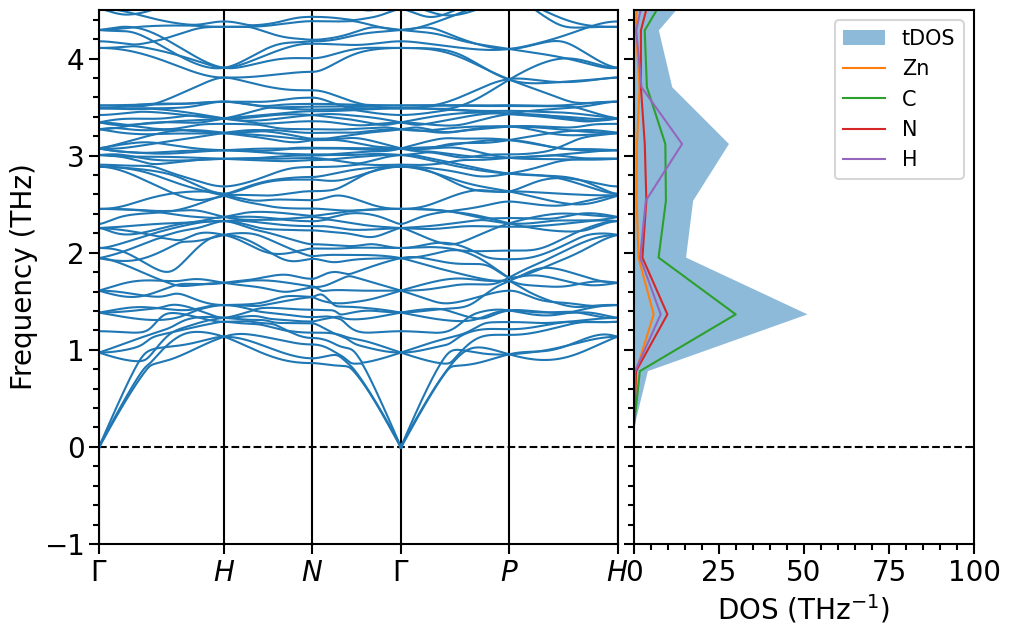

In [ ]:
plot = BandStructureDOSPlot()
plot.show_plot = True
plot.store_plot = True
plot.store_path = "."
plot.auto_set_axis_properties(set_y_label=False)
plot.ratio = (10, 6)
plot.subplot_ncols = 5
plot.subplot_gridspec = [(0, 1, 0, 3), (0, 1, 3, 5)]
plot.custom_linestyles = ["solid"]
plot.custom_colors = ["C0", "C1", "C2", "C3", "C4"]
plot.x_label = [None, r"DOS (THz$^{-1}$)"]
plot.y_label = ["Frequency (THz)", None]
plot.subplot_adjust = {"top": 1, "right": 1}
plot.y_range = [-1.0, 4.5]
plot.x_range = [0.0, 100.0]
plot.show_legend = [False, True]

plot.set_reference_cell(ref_cell)
plot.import_band_structure(data_label="Phonon Dispersion", **band_structure)
plot.import_total_dos("Phonon Dispersion", **tdos)
plot.import_projected_dos(
    "Phonon Dispersion",
    pdos["energy"],
    pdos["pdos"],
    sum_kinds=True,
    sum_principal_qn=True,
    sum_magnetic_qn=True,
)

_ = plot.plot(
    "Phonon Dispersion",
    plot_title="",
    plot_name="phonon_DOS_plot.png"
)


### Option B — Default plot with Phonopy

Use Phonopy’s built-in plotting to produce the phonon dispersion and DOS using the settings in `band-pdos.conf`.  
Phonopy will read your unit cell (`Bunitcell.inp`) and existing `FORCE_SETS`, write `phonopy.yaml`, and generate `band_dos.pdf`.



In [6]:
%%bash
phonopy --cp2k -c Bunitcell.inp -p -s band-pdos.conf

        _
  _ __ | |__   ___  _ __   ___   _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ | '_ \| | | |
 | |_) | | | | (_) | | | | (_) || |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___(_) .__/ \__, |
 |_|                            |_|    |___/
                                      2.29.1

Python version 3.11.10
Spglib version 2.6.0

"band-pdos.conf" was read as phonopy configuration file.
Calculator interface: cp2k
Crystal structure was read from "Bunitcell.inp".
Unit of length: angstrom
Band structure and mesh sampling mode
Settings:
  Force constants symmetrization: on
  Sampling mesh: [3 3 3]
  Supercell: [1 1 1]
  Primitive matrix (Auto):
    [-0.5  0.5  0.5]
    [ 0.5 -0.5  0.5]
    [ 0.5  0.5 -0.5]
Spacegroup: I23 (197)
Number of symmetry operations in supercell: 24
Use -v option to watch primitive cell, unit cell, and supercell structures.

Forces and displacements were read from "FORCE_SETS".
Computing force constants...
Max drift of force constants: 0.088389 (yy) 0.000001 (yy)
Max d

## 7) Checks

- Inspect the branches for **imaginary frequencies** (shown as negative values).  
- If they appear, decide whether they’re **physical** or **numerical**.

**Physical causes (real instabilities)**
- Soft modes related to a phase transition or an unstable structure at the chosen volume/pressure.
- A high-symmetry configuration sitting at a saddle point.

**Technical causes (spurious)**
- Supercell too small → increase supercell size.
- Loose SCF/force convergence or insufficient cutoffs (e.g., `CUTOFF`, `REL_CUTOFF`, grids).
- Displacement amplitude poorly chosen → adjust `--amplitude`.
- Inconsistent inputs (mismatch between `Bunitcell.inp` and force calculations, `PRIMITIVE_AXES`, or `symprec`).
- Missing **non-analytical term correction (NAC)** for polar materials.
- **Acoustic sum rule** not enforced → use `--asr` in Phonopy.

